In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.layers import Input, Dense, Conv2D, Flatten
from keras.models import Model, Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])        
    return X

### Data Load
- 'PL04496-03040' (prod_list[0]) 제품만을 대상으로
- 정상 데이터만으로 학습
- 전체 데이터로 테스트

In [3]:
isee_machine = pd.read_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label.csv')
prod_list = isee_machine.ProductNum.unique()

# prod_list[0] 제품에 대해서만 분석
isee_machine = isee_machine[isee_machine.ProductNum == prod_list[0]]    

analy_col = ['CycleTime', 'VpPosition', 'VpTime',
        'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
        'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
        'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
        'Zone1', 'Zone2', 'Zone3', 'Zone4'] 
isee_machine['NG_Label'] = isee_machine['NG'] + isee_machine['NG5']

# combined_label== 1인것을 정상으로 편입, 하나씩 낮춰줌
isee_machine['combined_label'] = [x-1 if x>1 else x for x in isee_machine['combined_label']] 
# 원래 combined_label== 3,4,5 인 것을 위험군으로 합침
isee_machine['combined_label'] = [2 if x>=2 else x for x in isee_machine['combined_label']]

- prop: 이상 비율 설정 (0.05876542354082906)

In [4]:
prop = isee_machine['NG'].sum()/len(isee_machine)

- 이상치 중 정상 추가

In [5]:
idx_labeled4 = isee_machine[isee_machine['combined_label']>=1].index.tolist()

for n in [40]:
    proba = []

    for id in idx_labeled4:
        temp_df_before = isee_machine.loc[id-n:id-1].sort_index(ascending=True).reset_index(drop=True)
        temp_df_after = isee_machine.loc[id+10:id+n-1+10].sort_index(ascending=False).reset_index(drop=True)
        proba.append((temp_df_before['NG'] * temp_df_before.index/n).sum() + (temp_df_after['NG'] * temp_df_after.index/n).sum())
        #proba.append((temp_df_after['NG'] * temp_df_after.index/n).sum())


    prob_df = pd.concat([pd.DataFrame(idx_labeled4, columns=['idx']),pd.DataFrame(proba, columns=['proba'])],axis=1)
    id_list = prob_df[prob_df.proba == 0]['idx'].values
    print("정상추가갯수: ", isee_machine.loc[id_list].groupby('combined_label')['combined_label'].count())
    isee_machine.loc[id_list,'combined_label'] = isee_machine.loc[id_list,'combined_label'] -1
    #isee_machine.set_value(prob_df[prob_df.proba == 0]['idx'].values,'combined_label', 0)

isee_machine['combined_label'].mask(isee_machine['combined_label']< 0, 0, inplace=True)

정상추가갯수:  combined_label
1    1743
2    1095
Name: combined_label, dtype: int64


-  정상치 중 이상 제외

In [6]:
idx_labeled0 = isee_machine[isee_machine['combined_label']< 5].index.tolist()

n = 40
proba = []

for id in idx_labeled0:
    #proba.append(isee_machine.loc[id:id+n-1]['NG'].sum())
    temp_df_before = isee_machine.loc[id-n:id-1].sort_index(ascending=True).reset_index(drop=True)
    temp_df_after = isee_machine.loc[id+10:id+n-1+10].sort_index(ascending=False).reset_index(drop=True)
    proba.append((temp_df_before['NG'] * temp_df_before.index/n).sum() + (temp_df_after['NG'] * temp_df_after.index/n).sum())
    #proba.append((temp_df_after['NG'] * temp_df_after.index/n).sum())

prob_df = pd.concat([pd.DataFrame(idx_labeled0, columns=['idx']),pd.DataFrame(proba, columns=['proba'])],axis=1)

print("평균:, ",prob_df.proba.mean(), " max: ",prob_df.proba.max())
print("전체 정상 갯수: ", len(prob_df[prob_df.proba == 0]['idx']))

평균:,  2.2918515180923333  max:  28.65
전체 정상 갯수:  19147


In [7]:
div = (prob_df.proba.max() - prob_df.proba.mean() * 4) / 3

t1 = prob_df.proba.max() - div * 3
t2 = prob_df.proba.max() - div * 2


#print(len(prob_df[(prob_df.proba > 0) & (prob_df.proba < 5)]['idx']))
print(len(prob_df[(t1 <= prob_df.proba) & (prob_df.proba < t2)]['idx']))
print(len(prob_df[t2 <= prob_df.proba]['idx']))

2724
893


In [8]:
isee_machine.set_value(prob_df[prob_df.proba >= t1]['idx'].values,'combined_label', 1)
isee_machine.set_value(prob_df[prob_df.proba >= t2]['idx'].values,'combined_label', 2)

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,creationTime,ModuleCount,CycleTime,VpPosition,VpTime,VpPressure,MaxInjectionPressure,InjectionEndPosition,PlasticizingTime,PlasticsEndPosotion,...,NG5,ProductNum,K_mahala_label,mahala_label,lof_label,gmm_label,IF_label,svm_label,combined_label,NG_Label
0,2018-09-01 19:13:00,270172.0,42.120,25.0,4.9900,60.0,80.0,22.90,13.0900,97.200,...,0,PL04496-03040,0,0,1,1,1,1,1,0
1,2018-09-01 19:14:00,270173.5,42.110,25.0,5.0050,61.0,81.5,16.10,13.1500,97.250,...,0,PL04496-03040,0,0,0,1,0,1,0,0
2,2018-09-01 19:15:00,270175.0,42.110,25.0,4.9600,61.0,82.0,15.10,13.7300,97.200,...,0,PL04496-03040,0,0,0,1,0,1,0,0
3,2018-09-01 19:16:00,270176.0,42.110,25.0,4.9700,61.0,82.0,14.00,14.1600,97.100,...,0,PL04496-03040,0,0,0,1,0,1,0,0
4,2018-09-01 19:17:00,270177.5,42.110,25.0,4.9450,62.5,83.5,16.30,14.4100,97.150,...,0,PL04496-03040,0,0,0,1,0,1,0,0
5,2018-09-01 19:18:00,270179.0,42.110,25.0,4.7900,61.0,83.0,12.70,15.7500,96.800,...,0,PL04496-03040,0,0,0,1,1,1,0,0
6,2018-09-01 19:19:00,270180.5,42.105,25.0,4.9300,62.5,84.0,16.60,15.2900,97.050,...,0,PL04496-03040,0,0,0,1,0,1,0,0
7,2018-09-01 19:20:00,270182.0,42.100,25.0,4.8000,62.0,84.0,16.30,15.0100,96.900,...,0,PL04496-03040,0,0,0,1,0,1,0,0
8,2018-09-01 19:21:00,270183.5,42.100,25.0,4.8300,62.5,71.5,19.95,14.8800,96.900,...,0,PL04496-03040,0,0,0,1,1,1,0,0
9,2018-09-01 19:22:00,270185.0,42.100,25.0,4.9000,61.0,84.0,16.10,14.1100,97.100,...,0,PL04496-03040,0,0,0,1,0,1,0,0


- input 데이터 셋 생성

In [122]:
w=60    # window size
s=10     # stride
n= 30    # 몇분 후랑 복원율 비교?

X = []
Xf = []
label = []
labelf = []

target_label = 'combined_label'

for c in isee_machine['CycleNum'].unique():
    df = isee_machine[isee_machine['CycleNum']==c]
    df = df.reset_index(drop=True)
    for i in range(int((len(df)-w)/s - n)):
        t_df_before = df.loc[s*i:s*i+w-1]
        t_sum_before = (t_df_before[target_label] ** 2).mean()
        
        t_df_after = df.loc[s*i+n:s*i+w-1+n]
        t_sum_after = (t_df_after[target_label] ** 2).mean()

        X.append(t_df_before[analy_col].values)
        label.append(t_sum_before)
        
        Xf.append(t_df_after[analy_col].values)
        labelf.append(t_sum_after)

X = np.array(X)
Xf = np.array(Xf)        

In [125]:
np.unique(label)

array([0.        , 0.01666667, 0.03333333, 0.05      , 0.06666667,
       0.08333333, 0.1       , 0.11666667, 0.13333333, 0.15      ,
       0.16666667, 0.18333333, 0.2       , 0.21666667, 0.23333333,
       0.25      , 0.26666667, 0.28333333, 0.3       , 0.31666667,
       0.33333333, 0.35      , 0.36666667, 0.38333333, 0.4       ,
       0.41666667, 0.43333333, 0.45      , 0.46666667, 0.48333333,
       0.5       , 0.51666667, 0.53333333, 0.55      , 0.56666667,
       0.58333333, 0.6       , 0.61666667, 0.63333333, 0.65      ,
       0.66666667, 0.68333333, 0.7       , 0.71666667, 0.73333333,
       0.75      , 0.76666667, 0.78333333, 0.8       , 0.81666667,
       0.83333333, 0.85      , 0.86666667, 0.88333333, 0.9       ,
       0.91666667, 0.93333333, 0.95      , 0.96666667, 0.98333333,
       1.        , 1.01666667, 1.03333333, 1.05      , 1.06666667,
       1.08333333, 1.1       , 1.11666667, 1.13333333, 1.15      ,
       1.16666667, 1.18333333, 1.2       , 1.21666667, 1.25   

In [124]:
np.unique(np.round(label, decimals=1))

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. ])

In [65]:
label = np.ceil(np.round(label, decimals=1)).tolist()
labelf = np.ceil(np.round(labelf, decimals=1)).tolist()

div = max(label + labelf)/2
label = [np.ceil(x/div) for x in label]
labelf = [np.ceil(x/div) for x in labelf]

label_df = pd.concat([pd.DataFrame(label, columns=['label0']),pd.DataFrame(labelf, columns=['label1'])], axis=1)

label_df['label0'] = label_df.label0.astype(int)
label_df['label1'] = label_df.label1.astype(int)

In [72]:
# temp = []
# for i in range(len(label_df)):
#     if label_df.loc[i].label0 ==0 and label_df.loc[i].label1==0:
#         temp.append(0)
#     elif label_df.loc[i].label0 ==0 and label_df.loc[i].label1==1:
#         temp.append(1)
#     elif label_df.loc[i].label0 ==1 and label_df.loc[i].label1==1:
#         temp.append(2)
#     elif label_df.loc[i].label0 ==1 and label_df.loc[i].label1==2:
#         temp.append(3)
#     elif label_df.loc[i].label0 ==2 and label_df.loc[i].label1==2:
#         temp.append(4) 
#     else: temp.append(-1)
# label_df['risk_label'] = temp

#label_df['risk_label'] = [np.max(x) for x in zip(label_df['label1'], label_df['label0'])]
#label_df['risk_label'] = (- label_df.label0 + label_df.label1 * 3) + 2
#label_df['risk_label'] = [np.max(i) for i in zip(label_df.label0, label_df.label1)]
label_df['risk_label'] = label_df.label0 + label_df.label1

In [73]:
normal_idx = label_df[(label_df.risk_label ==0)].index.tolist()
test_idx = label_df[(label_df.risk_label >=0)].index.tolist()

X_train = X[normal_idx]
X_future = Xf[normal_idx]

X_test = X[test_idx]
X_future_test = Xf[test_idx]

print("정상 데이터 수: ",len(normal_idx), " 전체 데이터 수 :", len(test_idx))

정상 데이터 수:  2447  전체 데이터 수 : 4407


In [74]:
prop = 1 - (len(normal_idx) / len(test_idx))
prop

0.4447469934195598

- scale

In [75]:
# 정상 데이터로만 scale
# Initialize a scaler using the training data.
scaler = MinMaxScaler().fit(np.concatenate((flatten(X_train),flatten(X_future)),axis=0))

scaled_train = scale(X_train, scaler)
scaled_future = scale(X_future, scaler)

# 전체 데이터로 테스트
scaled_X = scale(X_test, scaler)
scaled_Xf = scale(X_future_test, scaler)

In [76]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Dropout, RepeatVector
from keras.utils import plot_model

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

input_data = Input(shape=X_train.shape[1:])
x = LSTM(units=8, activation='relu', input_shape = (timesteps, n_features), return_sequences=True)(input_data)
x = LSTM(units=4, activation='relu', return_sequences=True)(x)
#x = RepeatVector(timesteps)(x)

x = LSTM(units=4, activation='relu', return_sequences=True)(x)
x = LSTM(units=8, activation='relu', return_sequences=True)(x)
decoded = TimeDistributed(Dense(units=n_features))(x)

autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

### fit model
autoencoder.fit(scaled_train, scaled_future, epochs= 10, batch_size=128, shuffle=True, verbose=1)
autoencoder.summary()
#plot_model(autoencoder, show_shapes=True)  # , to_file='reconstruct_lstm_autoencoder.png'

Epoch 1/10
2447/2447 [==============================] - 6s 3ms/step - loss: 0.2643
Epoch 2/10
2447/2447 [==============================] - 2s 899us/step - loss: 0.2453
Epoch 3/10
2447/2447 [==============================] - 2s 970us/step - loss: 0.2240
Epoch 4/10
2447/2447 [==============================] - 2s 930us/step - loss: 0.2000
Epoch 5/10
2447/2447 [==============================] - 2s 967us/step - loss: 0.1715
Epoch 6/10
2447/2447 [==============================] - 2s 890us/step - loss: 0.1460
Epoch 7/10
2447/2447 [==============================] - 2s 870us/step - loss: 0.1215
Epoch 8/10
2447/2447 [==============================] - 2s 915us/step - loss: 0.0965
Epoch 9/10
2447/2447 [==============================] - 2s 1ms/step - loss: 0.0788
Epoch 10/10
2447/2447 [==============================] - 3s 1ms/step - loss: 0.0679
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)   

In [77]:
# demonstrate recreation
lstm_predict = autoencoder.predict(scaled_X)

lstm_predict = lstm_predict.reshape(lstm_predict.shape[0], lstm_predict.shape[1]* lstm_predict.shape[2])
X2 = scaled_Xf.reshape(scaled_Xf.shape[0], scaled_Xf.shape[1]* scaled_Xf.shape[2])

In [85]:
prop = 0.05

In [101]:
### calculate MSE
temp_df = pd.DataFrame(mean_squared_error(X2.T, lstm_predict.T, multioutput='raw_values'), columns=['mse'])
temp_df = pd.concat([temp_df,label_df.loc[test_idx].reset_index(drop=True)], axis=1)

In [102]:
temp_df

,mse,label0,label1,risk_label
0,0.049737,1,1,2
1,0.048868,0,1,1
2,0.049010,1,1,2
3,0.049196,1,1,2
4,0.052180,1,1,2
5,0.054219,1,1,2
6,0.057359,1,1,2
7,0.060053,1,1,2
8,0.062271,1,1,2
9,0.063065,1,1,2


In [118]:
k = sorted(temp_df.mse.values, reverse=True)
t = np.ceil(len(temp_df.mse.values) * prop).astype(int)

lstmAE_label = []
t4 = len(temp_df[temp_df.risk_label==4])
t3 = len(temp_df[temp_df.risk_label>=3])
t2 = len(temp_df[temp_df.risk_label>=2])
t1 = len(temp_df[temp_df.risk_label>=1])

for x in temp_df.mse.values:
    if x >= k[t4]: lstmAE_label.append(4)
    elif x < k[t4] and x >= k[t3]: lstmAE_label.append(3)
    elif x < k[t3] and x >= k[t2]: lstmAE_label.append(2)
    elif x < k[t2] and x >= k[t1]: lstmAE_label.append(1)
    else: lstmAE_label.append(0)
    

temp_df['lstmAE_label'] = lstmAE_label

In [87]:
# k = sorted(temp_df.mse.values, reverse=True)
# t = np.ceil(len(temp_df.mse.values) * prop).astype(int)

# lstmAE_label = []
# for x in temp_df.mse.values:
#     if x >= k[int(t/2*1)]: lstmAE_label.append(2)
#     elif x < k[int(t/2*1)] and x >= k[int(t/2*2)]: lstmAE_label.append(1)
#     else: lstmAE_label.append(0)
    

# temp_df['lstmAE_label'] = lstmAE_label
# temp_df = pd.concat([temp_df,label_df.loc[test_idx].reset_index(drop=True)], axis=1)

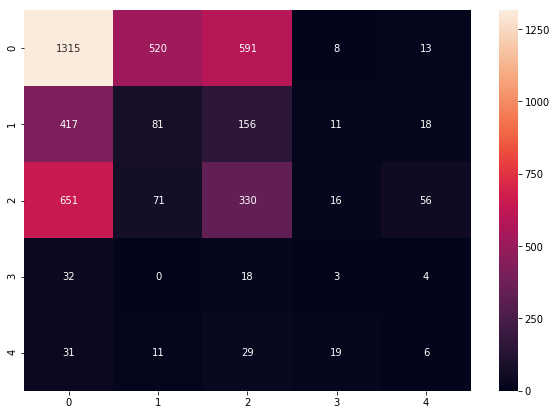

In [119]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

#y = [0 if x in [0,2] else x for x in temp_df.risk_label]

df_cm = confusion_matrix(temp_df.risk_label, temp_df.lstmAE_label)
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

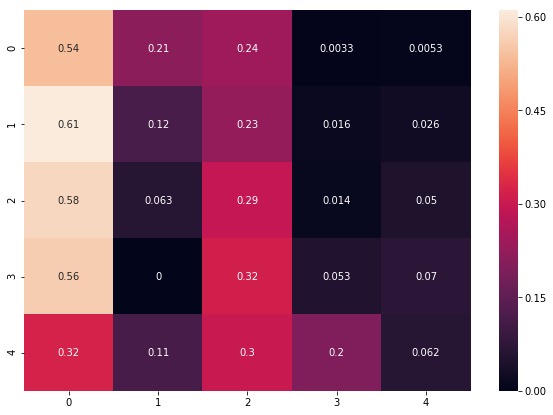

In [120]:
temp_mat = []
for i in range(len(df_cm.sum(axis=1))):    
    temp_mat.append(df_cm[i] / df_cm.sum(axis=1)[i])
    
plt.figure(figsize=(10,7))
sn.heatmap(temp_mat, annot=True)

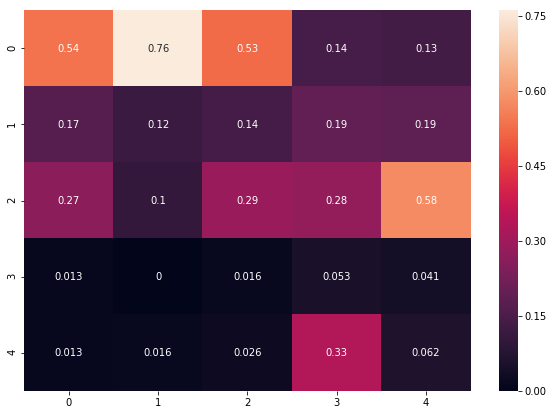

In [121]:
temp_mat = []
for i in range(len(df_cm.sum(axis=1))):    
    temp_mat.append(df_cm[i] / df_cm.sum(axis=0))
    
plt.figure(figsize=(10,7))
sn.heatmap(temp_mat, annot=True)

In [83]:
print(classification_report(temp_df.risk_label, temp_df.lstmAE_label))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54      2447
           1       0.13      0.09      0.11       683
           2       0.13      0.06      0.08      1124
           3       0.01      0.11      0.02        57
           4       0.09      0.44      0.14        96

   micro avg       0.34      0.34      0.34      4407
   macro avg       0.18      0.25      0.18      4407
weighted avg       0.35      0.34      0.34      4407



In [230]:
temp_df.groupby(['risk_label'])[['mse']].describe().T

risk_label            0           1             2           3          4
mse count   2447.000000  683.000000   1124.000000   57.000000  96.000000
    mean       0.063388    0.078202     17.604819   11.907971   0.152341
    std        0.048833    0.105405    563.690689   48.872960   0.224878
    min        0.026920    0.026907      0.027854    0.033928   0.034802
    25%        0.044029    0.044986      0.047752    0.056227   0.059802
    50%        0.060379    0.059468      0.060951    0.061132   0.076130
    75%        0.074030    0.074948      0.080656    0.080599   0.146152
    max        0.898310    1.207076  18895.571567  217.471899   1.007446

### Visualizing the Graph

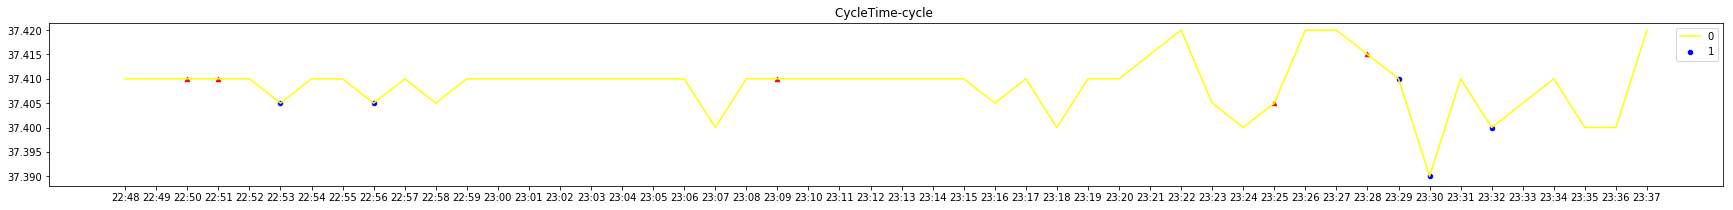

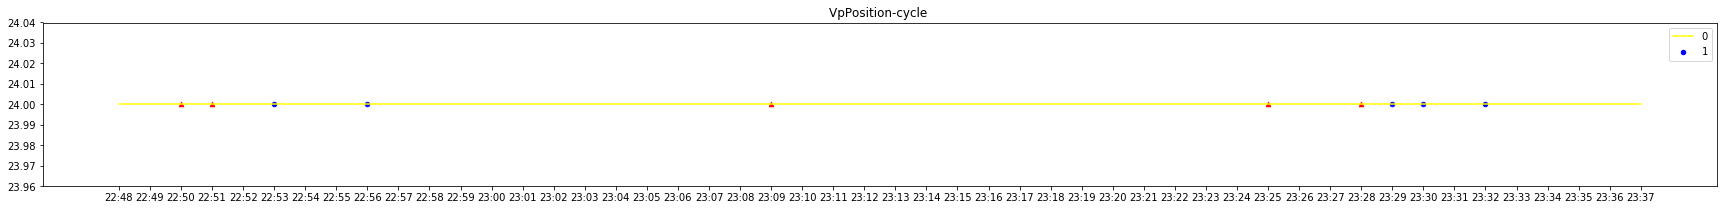

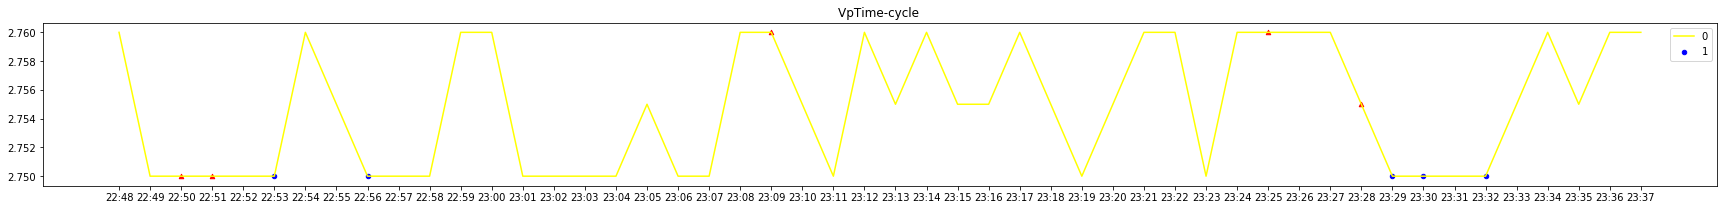

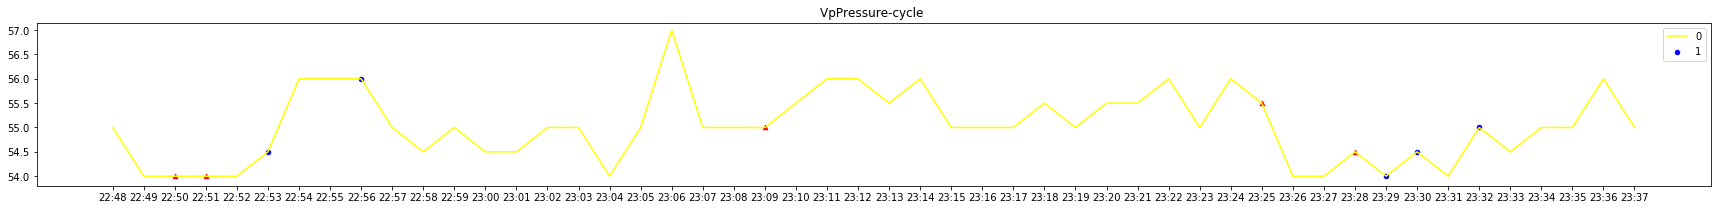

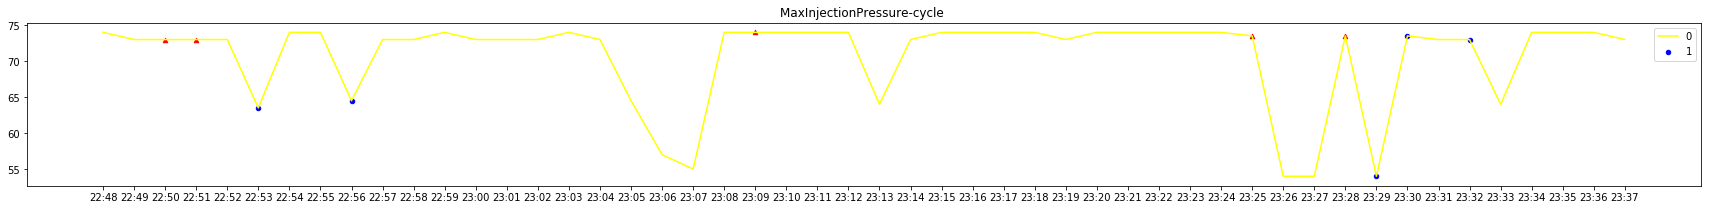

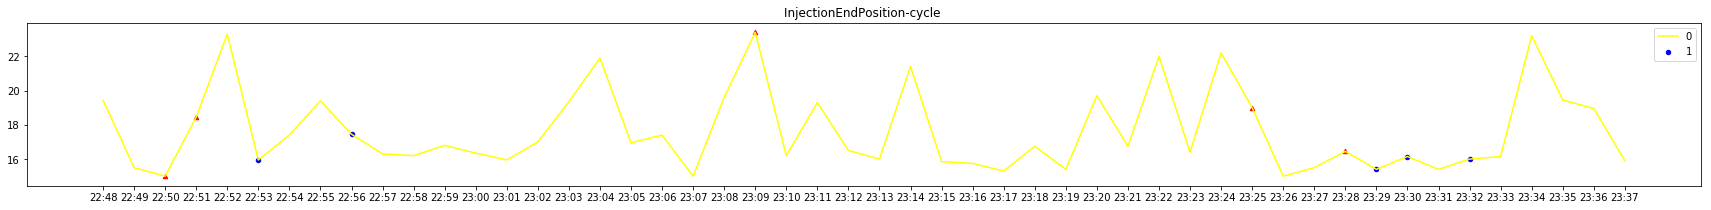

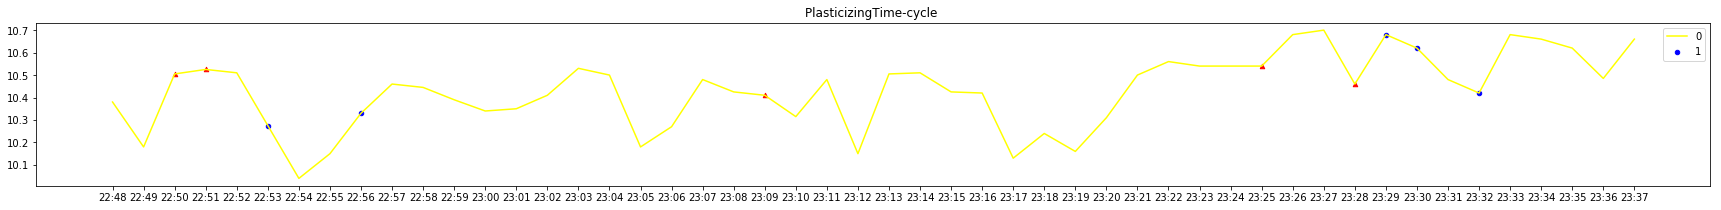

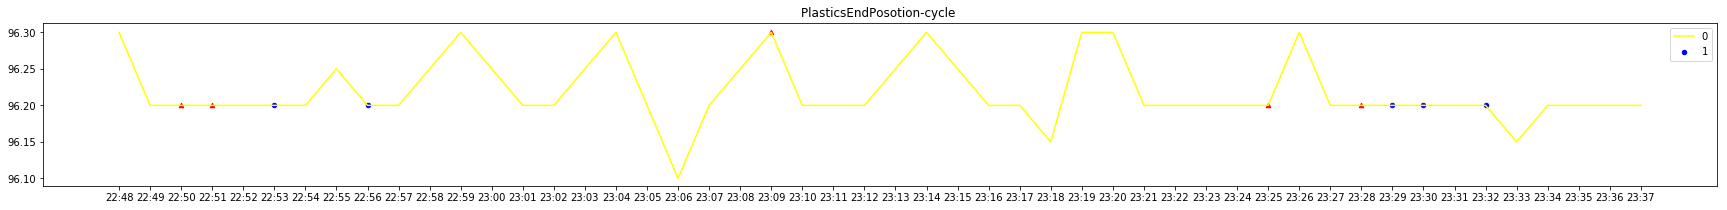

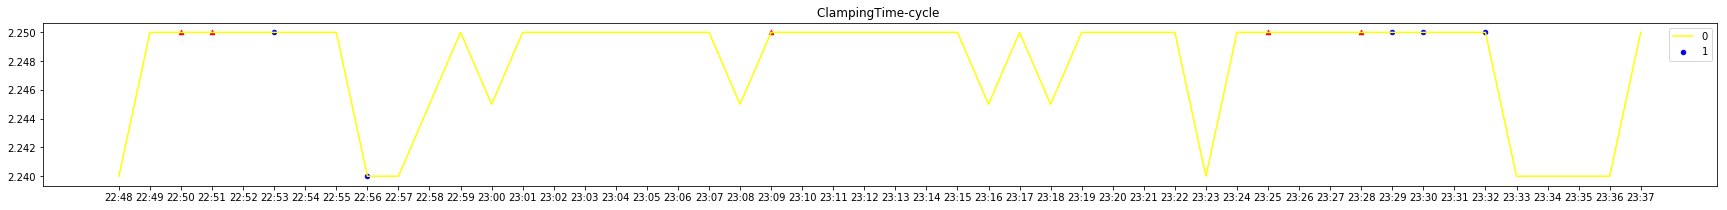

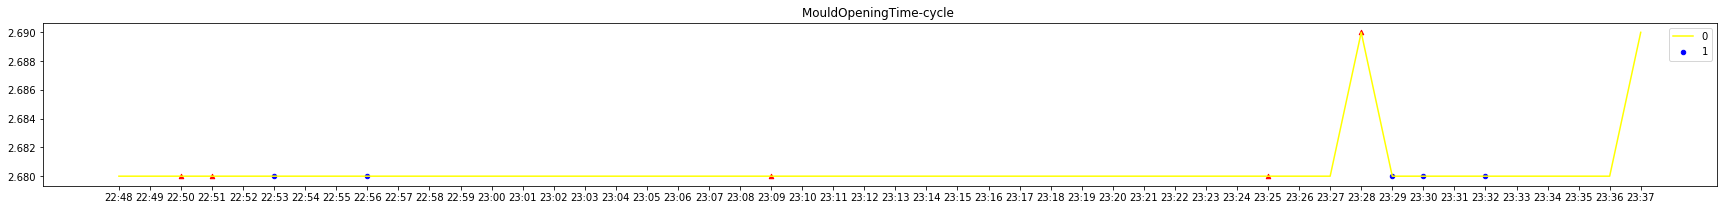

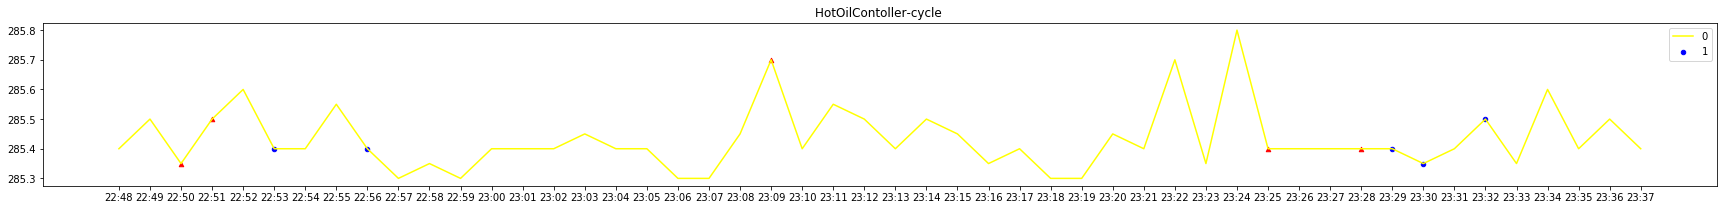

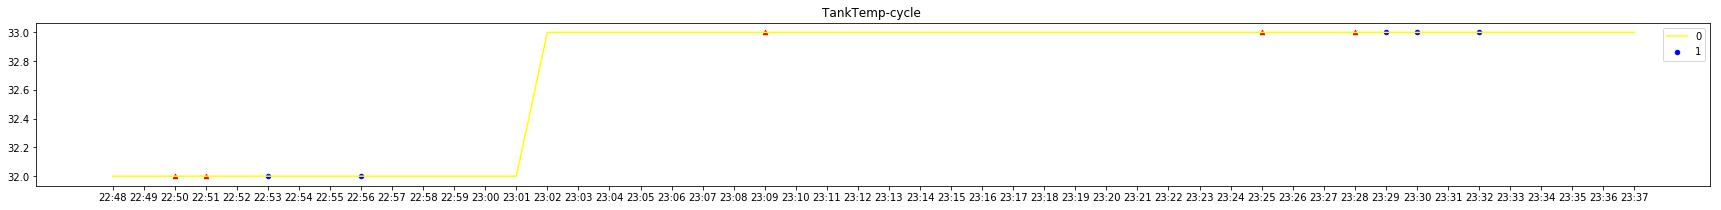

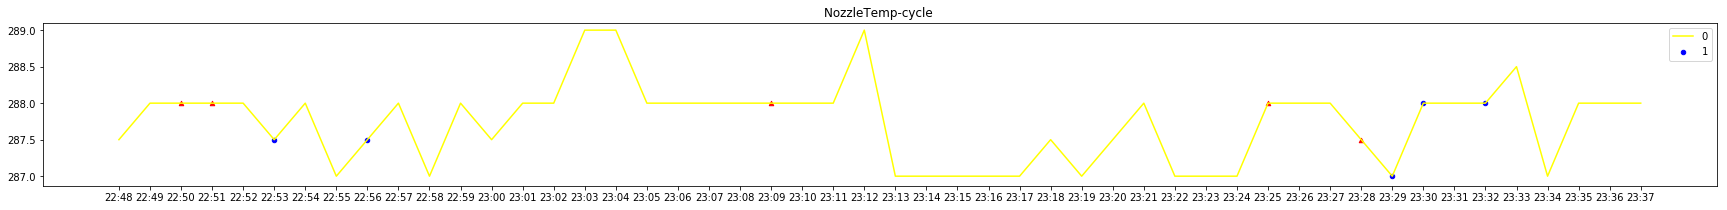

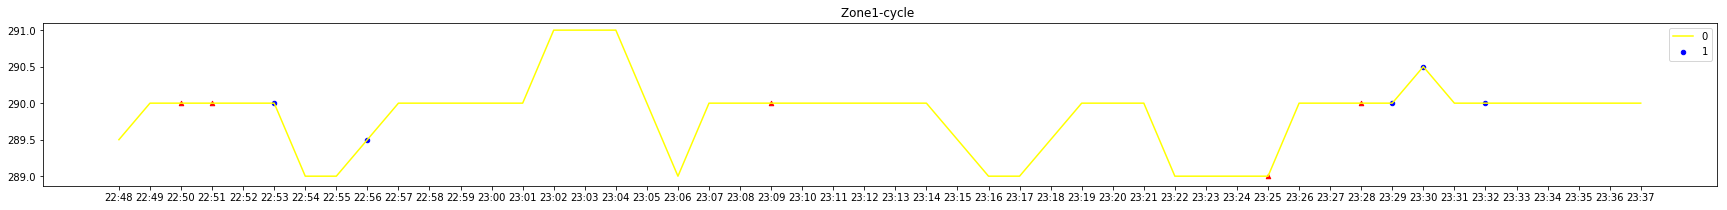

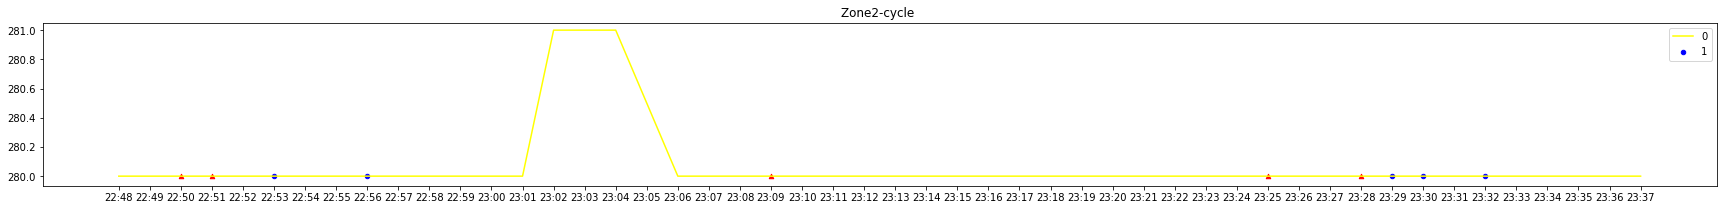

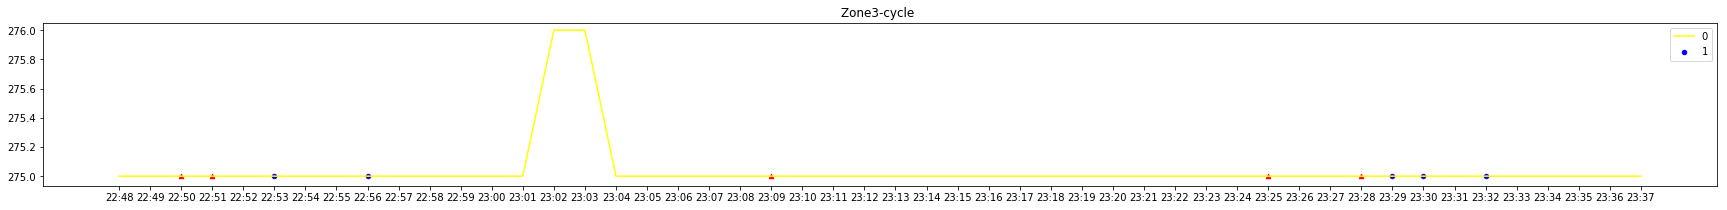

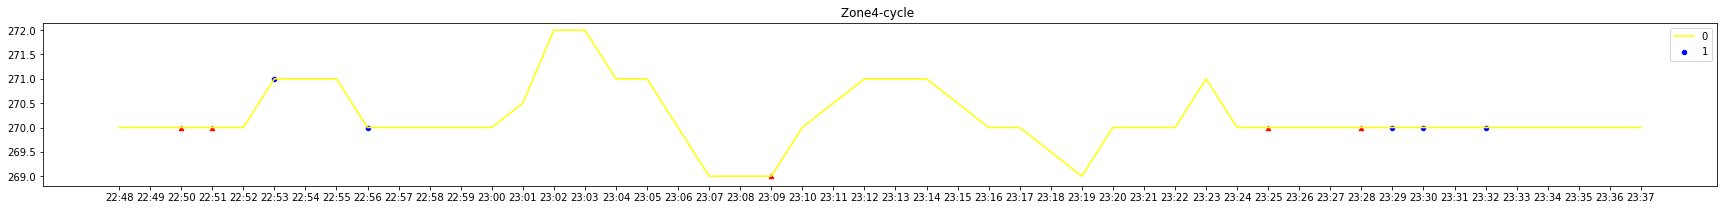

In [234]:
df_name = isee_machine[isee_machine.CycleNum==8][100:150]
df_name.creationTime = pd.to_datetime(df_name.creationTime)
df_name = df_name.set_index([[x.strftime('%H:%M') for x in df_name.creationTime]])

NG_target = 'combined_label'
c_dic= {0:'yellow', 1:'blue', 2:'blue', 3:'red', 4:'magenta', 5:'red'}

for i in range(len(analy_col)):
    fig, ax1 = plt.subplots(1,1, sharey=True, figsize=(30,3))
    ax1.plot(df_name.index, df_name[analy_col[i]], c=c_dic[0], label=0)
    
    for n in np.unique(df_name[NG_target]):
        temp = df_name[df_name[NG_target]==n]
        
        if n >= 1 :  
            ax1.scatter(temp.index, temp[analy_col[i]], c=c_dic[n], label=n, s=20)
            ax1.legend()
            ax1.set_title(analy_col[i]+'-cycle ') # + str(cycle_num)
    ax1.scatter(df_name[df_name.NG==1].index, df_name[df_name.NG==1][analy_col[i]], c=c_dic[3], s=20, marker='^')

### Option) One class SVM
One class SVM 학습에 combined_label 정상(0)을 사용하여, 나머지(1,2,3,4,5) 분류
- 목적: combined_label의 성능 테스트
- 결과: 3,4,5는 이상치가 확실한 듯

In [38]:
normal_df = isee_machine[isee_machine.combined_label==0]
t_scaler = StandardScaler().fit(normal_df[analy_col])

In [39]:
normal_scaled_X = t_scaler.transform(normal_df[analy_col])
scaled_total = t_scaler.transform(isee_machine[analy_col])

In [40]:
from sklearn import svm

clf = svm.OneClassSVM(nu=prop, kernel='rbf')
clf.fit(normal_scaled_X)

y_pred = clf.predict(scaled_total)

y_pred = [1 if x == -1 else 0 for x in y_pred]

In [41]:
df = pd.DataFrame(y_pred, columns=['svm_label'])

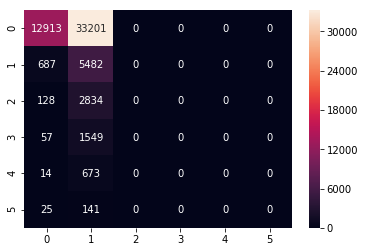

In [42]:
### plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(isee_machine['combined_label'], df['svm_label']))
plt.figure()
sn.heatmap(df_cm, annot=True, fmt='d')

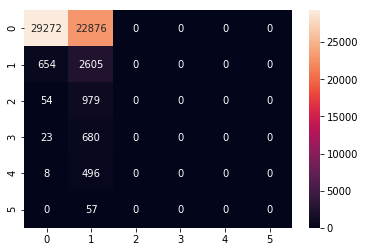

In [84]:
### plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(isee_machine['combined_label'], df['svm_label']))
plt.figure()
sn.heatmap(df_cm, annot=True, fmt='d')

In [69]:
print(classification_report(isee_machine['combined_label'], df['svm_label']))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     48666
           1       0.27      0.53      0.36      4881
           2       0.00      0.00      0.00      1548
           3       0.00      0.00      0.00      1574
           4       0.00      0.00      0.00       916
           5       0.00      0.00      0.00       119

   micro avg       0.84      0.84      0.84     57704
   macro avg       0.20      0.25      0.22     57704
weighted avg       0.83      0.84      0.83     57704



C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
